In [1]:
#Sezione 1: Definizione classi
class Parameter:
    def __init__(self):
        self.hp=1   #prior
        self.exp_value=None #valore atteso        
        
class Node:
    def __init__(self,name,levels,parents):
        self.name=name    
        self.levels=levels    #lista dei livelli del nodo (str)
        self.parents=parents  #lista dei nodi padre (node)
        self.l_num={}   #dizionario che associa un numero a ciasun livello del nodo
        for l in range(len(self.levels)):
            self.l_num[self.levels[l]]=l
        self.num_config=len(self.levels)   
        self.num_config_parents=1
        for p in self.parents:
            self.num_config_parents=self.num_config_parents*len(p.levels)  #numero configurazioni dei padri del nodo
        self.num_config=self.num_config*self.num_config_parents #numero delle configurazioni del nodo
        if parents!=[]:
            self.pc_l=[] #lista che associa la config dei padri ai rispettivi livelli (utilizzata in print_prob)
            self.fill_pcl(self.parents,self.pc_l)
        self.parameters=[]   #lista dei parametri associati al nodo
        for i in range(self.num_config):
            self.parameters.append(Parameter())
    
    def fill_pcl(self,p,pc_l,lev=[]): #metodo che definisce la lista pc_l
        for lp in p[0].levels:
            lev.append(lp)
            if len(p)>1:
                self.fill_pcl(p[1:],pc_l,lev)
                lev.pop()
            else:
                pc_l.append(list(lev))
                lev.pop()
    
    def get_factor(self,parents):
        #metodo per ottenere il fattore moltiplicativo della codifica posizionale utilizzata nella funzione get_config
        factor=1                    
        for p in parents:
            factor=factor*len(p.levels)
        return factor
            
    def get_config(self,node_level,parents_config=[]):
        #metodo che restituisce, dati il livello del nodo e quello di...
        #...ciascun padre,il numero di config corrispondente
        config=0 
        for p in range(len(self.parents)):
            if p<(len(self.parents)-1):
                config=config+self.parents[p].l_num[parents_config[p]]*self.get_factor(self.parents[(p+1):])
            else:
                config=config+self.parents[p].l_num[parents_config[p]]
        config=config+self.l_num[node_level]*self.num_config_parents
        return config
    
    def get_config_by_num(self,num_level,num_p_config):     
        #metodo che, dati il numero associato livello del nodo e il numero associato al livello dei padri,..
        #...restituisce il numero di config del nodo 
        return num_p_config+num_level*self.num_config_parents  
    
            
class BayesianNetwork:
    def __init__(self):
        self.nodes={}
        
    def add_node(self,name,levels,parents_name):
        parents=[]
        for p in parents_name:
            parents.append(self.nodes[p])
        node=Node(name,levels,parents)
        self.nodes[name]=node
        
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_node_levels(self,node):
        return self.nodes[node].levels
    
    def get_node_parents(self,node):
        parents=[]
        for p in self.nodes[node].parents: 
            parents.append(p.name)
        return parents
    
    def get_level_by_conf(self,node,conf):  
        #metodo che restituisce il livello del nodo dato il numero di config associato
        for l in range(len(self.nodes[node].levels)):
            if l==int(conf/self.nodes[node].num_config_parents):
                return self.nodes[node].levels[l]
    
    def get_parents_level_by_conf(self,node,conf):  
        #metodo che restituisce il livello dei padri dato il numero di config associato
        if self.nodes[node].parents!=[]:
            conf=conf%self.nodes[node].num_config_parents
            return self.nodes[node].pc_l[conf]
        return []
        
    def get_prob(self,nodes_conf): #metodo ricorsivo utilizzato nel metodo get_prob_list()
        prob=1
        pos_n=0
        for node in self.nodes.values():
            parents_conf=[]
            pos_p=0
            for p in self.nodes.values():
                if p in node.parents:
                    parents_conf.append(nodes_conf[pos_p])
                pos_p+=1
            prob=prob*node.parameters[node.get_config(nodes_conf[pos_n],parents_conf)].exp_value
            pos_n+=1
        return prob
    
    def get_prob_list(self,nodes,nodes_conf,prob_list): 
        #funzione che calcola la probabilità stimata di ogni configurazione della rete e la inserisce nella lista prob_list
        #la lista nodes_conf memorizza la configurazione della rete
        #quando si invoca la funzione le si passa bn.nodes.values() e due liste vuote 
        for l in nodes[0].levels:
            nodes_conf.append(l)
            if len(nodes)>1:
                self.get_prob_list(nodes[1:],nodes_conf,prob_list)
                nodes_conf.pop()
            else:
                prob_list.append(self.get_prob(nodes_conf))
                nodes_conf.pop()
    
    def copy_structure(self,bn):
        for node in bn.get_nodes():
            self.add_node(node,bn.get_node_levels(node),bn.get_node_parents(node))
            
    def print_prob(self):
        for n in self.get_nodes():
            print("Node: "+n+" (Parents:"+str(self.get_node_parents(n))+"):\n")
            for conf in range(self.nodes[n].num_config):
                print("   N_level: "+self.get_level_by_conf(n,conf)+" P_levels: "+str(self.get_parents_level_by_conf(n,conf))+" Prob: "+str(self.nodes[n].parameters[conf].exp_value))
            print("\n")    
                
        
 

In [2]:
#Sezione 2: Definizione della funzione per l'apprendimento bayesiano dei parametri
def BayesianLearning(bn,df):
    N={}                           #dizionario che associa ad ogni nodo il numero di volte in cui è in una certa config
    for node in df.columns:        #ciclo che inizializza a 0 tutti gli N_ijk
        N[node]=[]
        for c in range(bn.nodes[node].num_config):
            N[node].append(0)
        
    for line in range(len(df.index)): #si scorrono le righe del db e si incrementa gli N_ijk
        for node in df.columns:
            parents_config=[]
            for p in bn.nodes[node].parents:
                parents_config.append(df.iloc[line][p.name])
            config=bn.nodes[node].get_config(df.iloc[line][node],parents_config)
            N[node][config]+=1

    for node in bn.nodes.values():
        norm=[]   #lista i cui ogni elemento corrisponde al coef di norm. di quella config dei padri del nodo
        for conf in range(node.num_config_parents):
            norm.append(0)
        
        for conf in range(node.num_config):   #calcolo norm[]
            norm[conf%node.num_config_parents]=norm[conf%node.num_config_parents]+node.parameters[conf].hp+N[node.name][conf]

        for conf in range(node.num_config): #calcolo il valore atteso
            node.parameters[conf].exp_value=round((node.parameters[conf].hp+N[node.name][conf])/norm[conf%node.num_config_parents],2)
       
        for p in range(node.num_config_parents):
            sum=0
            for l in range(1,len(node.levels),1):
                sum=sum+node.parameters[node.get_config_by_num(l,p)].exp_value
            node.parameters[node.get_config_by_num(0,p)].exp_value=round(1-sum,2)

In [3]:
#Sezione 3: Creazione rete
from pgmpy.readwrite import BIFReader
reader = BIFReader("asia.bif")
bn=BayesianNetwork()
for node in reader.get_variables():
    bn.add_node(node,reader.get_states()[node],reader.get_parents()[node])

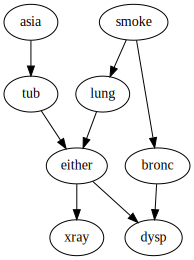

In [4]:
#Sezione 4: Rappresentazione grafica della rete
from graphviz import Digraph
dot = Digraph()
for node in bn.get_nodes():
    dot.node(node)
    for p in bn.get_node_parents(node):
        dot.edge(p,node)
display(dot)

In [5]:
#Sezione 5: Creazione della rete di riferimento
import numpy
def read_prob(prob,p_list):        #funzione che legge le cpd dal modello e le inserisce in un vettore
    if type(prob) is numpy.float64:
            p_list.append(prob)
    else:
        for ind in prob:
            read_prob(ind,p_list)   

            
from pgmpy.models.BayesianModel import BayesianModel
from pgmpy.factors.discrete import TabularCPD   
model=reader.get_model()         
nodes_prob={}   #dizionario che associa ad ogni nodo la lista delle prob delle sue configurazioni
for node in model.nodes(): #leggo le cpd del modello
    prob_list=[]
    for prob in model.get_cpds(node).values:
        read_prob(prob,prob_list)
        nodes_prob[node]=prob_list

rbn=BayesianNetwork()
rbn.copy_structure(bn)
for node in reader.get_variables():
    rbn.add_node(node,reader.get_states()[node],reader.get_parents()[node])
for node in rbn.get_nodes():  #inserisco le probabilità lette in precedenza nella rete bayesiana
    for config in range(rbn.nodes[node].num_config):
        rbn.nodes[node].parameters[config].exp_value=nodes_prob[node][config]


In [6]:
#Sezione 6: Divergenza di Jensen-Shannon
import math as m
def JS_divergence(bn1,bn2):
    prob_list_bn1=[]
    nodes_conf_bn1=[]  
    bn1.get_prob_list(list(bn1.nodes.values()),nodes_conf_bn1,prob_list_bn1)

    prob_list_bn2=[]
    nodes_conf_bn2=[]  
    bn2.get_prob_list(list(bn2.nodes.values()),nodes_conf_bn2,prob_list_bn2)
    
    if len(prob_list_bn1)!=len(prob_list_bn2): return -1 
    
    div=0
    for ind in range(len(prob_list_bn1)):
        if prob_list_bn2[ind]!=0:
            div=div+prob_list_bn2[ind]*m.log2(prob_list_bn2[ind]/((prob_list_bn2[ind]+prob_list_bn1[ind])/2))
        if prob_list_bn1[ind]!=0:
            div=div+prob_list_bn1[ind]*m.log2(prob_list_bn1[ind]/((prob_list_bn1[ind]+prob_list_bn2[ind])/2))
    return div
    

Generating for node: bronc:   0%|                                                                | 0/8 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: xray: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 362.88it/s]


Generating for node: xray: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 425.76it/s]


Generating for node: xray: 100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 86.47it/s]


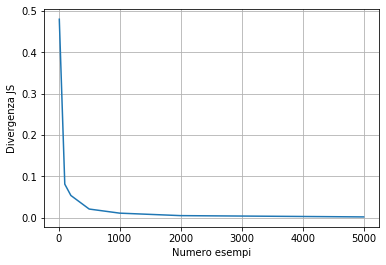

In [7]:
#Sezione 7: Apprendimento e calcolo della divergenza al variare della dimensione dei datasets
import matplotlib.pyplot as plt

from pgmpy.sampling import BayesianModelSampling
inference = BayesianModelSampling(model)
n_example=[10,100,200,500,1000,2000,5000]
avg_div=[]
cycle=[100,100,100,50,20,10,5]  #numero di cicli per calcolare la media
for ind in range(len(n_example)):
    div=[]
    for c in range(cycle[ind]):
        df=inference.forward_sample(n_example[ind], return_type='dataframe')
        BayesianLearning(bn,df)
        div.append(JS_divergence(bn,rbn))
    s=0
    for d in div: s=s+d
    avg_div.append(s/cycle[ind])

plt.plot(n_example,avg_div)
plt.xlabel("Numero esempi")
plt.ylabel("Divergenza JS")
plt.grid()
plt.show()

In [8]:
#Sezione 8: Stampa delle probabilità apprese dall'ultimo dataframe
bn.print_prob()

Node: asia (Parents:[]):

   N_level: yes P_levels: [] Prob: 0.01
   N_level: no P_levels: [] Prob: 0.99


Node: tub (Parents:['asia']):

   N_level: yes P_levels: ['yes'] Prob: 0.14
   N_level: yes P_levels: ['no'] Prob: 0.01
   N_level: no P_levels: ['yes'] Prob: 0.86
   N_level: no P_levels: ['no'] Prob: 0.99


Node: smoke (Parents:[]):

   N_level: yes P_levels: [] Prob: 0.5
   N_level: no P_levels: [] Prob: 0.5


Node: lung (Parents:['smoke']):

   N_level: yes P_levels: ['yes'] Prob: 0.09
   N_level: yes P_levels: ['no'] Prob: 0.01
   N_level: no P_levels: ['yes'] Prob: 0.91
   N_level: no P_levels: ['no'] Prob: 0.99


Node: bronc (Parents:['smoke']):

   N_level: yes P_levels: ['yes'] Prob: 0.61
   N_level: yes P_levels: ['no'] Prob: 0.29
   N_level: no P_levels: ['yes'] Prob: 0.39
   N_level: no P_levels: ['no'] Prob: 0.71


Node: either (Parents:['lung', 'tub']):

   N_level: yes P_levels: ['yes', 'yes'] Prob: 0.67
   N_level: yes P_levels: ['yes', 'no'] Prob: 1.0
   N_level: 